In [1]:
import numpy as np
import rebound as rb
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
from ResonanceEquationsOfMotions import ResonanceEquations
from NbodySimulationUtilities import get_simarchive_integration_results
from ResonantRV_Utils import acr_function

In [3]:
res_eqs = ResonanceEquations(3,1,n_quad_pts=51)
res_eqs.m1 = 1e-3
res_eqs.m2 = 1e-3

In [4]:
# Generate ACR equilibrium configuration

# Use acr_function to get planet eccentricities of an ACR configuration
acrfn = acr_function(3,1)
D_by_Dmax = 0.5
e1,e2 = acrfn(res_eqs.m2/res_eqs.m1,D_by_Dmax)

# approximate semi-major axes at equilibrium
a1,a2 = 1, 1.5**(2/3)

# resonant angles at equilibrium
theta1,theta2 = 0,np.pi

# Find exact equilibrium configuration
els = [a1,e1,theta1,a2,e2,theta2]
guess = res_eqs.orbels_to_dyvars(els)

eq = res_eqs.find_equilibrium(guess)

In [5]:
# Get a rebound simulation at equilibrium
sim,_ = res_eqs.dyvars_to_rebound_simulation(eq)

# compute synodic period
Tsyn= 2*np.pi/(sim.particles[1].n-sim.particles[2].n)

# create simulation archive and integrate for synodic period
sim.automateSimulationArchive("./sa.bin",Tsyn/100)
sim.integrate(Tsyn)

# Read in results
sa = rb.SimulationArchive("./sa.bin")
nb_results = get_simarchive_integration_results(sa)

# Add nb_results entry for resonant angles
nb_results['theta']=np.mod(
    np.array([res_eqs.k-res_eqs.j,res_eqs.j]) @ nb_results['l']  - nb_results['pomega']
    ,2*np.pi)

In [6]:
# Calculate mean elements corresponding to equilibrium
mean_els = res_eqs.dyvars_to_orbels(eq)

# Generate osculating values of dynamical variables
Qvals = np.linspace(0,2*np.pi,256)
osc_dyvars = res_eqs.mean_to_osculating_dyvars(Qvals,eq)

# Convert osculating dynamical variables to orbital elements
osc_els = np.transpose([res_eqs.dyvars_to_orbels(o) for o in osc_dyvars.T])


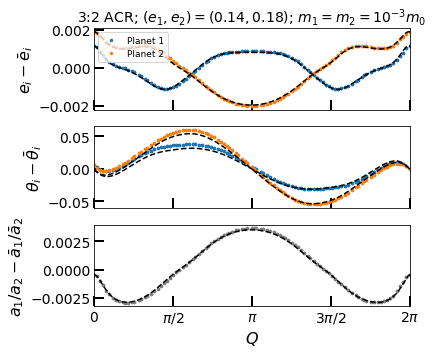

In [8]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(6,5))


# synodic angle from N-body simulation
psi = np.mod(nb_results['l'][1]-nb_results['l'][0],2*np.pi)

# Nbody eccentricities
ax[0].plot(psi,(nb_results['e'][0] - mean_els[1]),'.',label='Planet 1')
ax[0].plot(psi,(nb_results['e'][1] - mean_els[4]),'.',label='Planet 2')

# Nbody resonant angles
ax[1].plot(psi,(np.mod(nb_results['theta'][0] + np.pi,2*np.pi) - np.pi),'.')
ax[1].plot(psi,(np.mod(nb_results['theta'][1] ,2*np.pi) - np.pi),'.')

# Nbody semi-major axis ratio
ax[2].plot(psi,(nb_results['a'][0]/nb_results['a'][1] - (mean_els[0]/mean_els[3]))*1e0,'.',color='gray')
       
# Analytic eccentricities
ax[0].plot(Qvals,(osc_els[1] - mean_els[1]),'k--')
ax[0].plot(Qvals,(osc_els[4] - mean_els[4]),'k--')

# Analytic resonant angles
ax[1].plot(Qvals,(osc_els[2]-mean_els[2]),'k--')
ax[1].plot(Qvals,(osc_els[5]-mean_els[5]),'k--')


# Analytic semi-major axis ratio
ax[2].plot(Qvals,(osc_els[0]/osc_els[3] - (mean_els[0]/mean_els[3])),'k--')

# Cosmetics...
ax[0].legend(loc='upper left')
ax[0].set_ylabel(r"$e_i-\bar{e}_i$",fontsize=16)
ax[2].set_ylabel(r"${a_1}/{a_2}-{\bar{a}_1}/{\bar{a}_2}$",fontsize=16)
ax[1].set_ylabel(r"$\theta_i-\bar{\theta}_i$",fontsize=16)
ax[2].set_xlabel(r"$Q$",fontsize=16)
for a in ax:
    a.tick_params(direction='in',size=10,labelsize=14,width=2)
ax[2].set_xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi])
ax[2].set_xticklabels([r"$0$",r"$\pi/2$",r"$\pi$",r"$3\pi/2$",r"$2\pi$"])
ax[2].set_xlim(0,2*np.pi)
plt.subplots_adjust(hspace=0.02)

# ax[0].set_title(r"3:2 ACR; $e_1={:.2f}$; $e_2={:.2f}$ ; m_1=m_2=10^{{-3}}m_0$".format(mean_els[1],mean_els[4]))
ax[0].set_title("3:2 ACR; $(e_1,e_2)=({:.2f},{:.2f})$; $m_1=m_2=10^{{-3}}m_0$".format(mean_els[1],mean_els[4]),fontsize=14)
plt.tight_layout()